In [38]:
from ACAgraphML.Dataset import ZINC_Dataset
from ACAgraphML.Transforms import OneHotEncodeFeat, BagOfPathsTransform, SteadyStateTransform
import torch_geometric.transforms as T
from torch.nn.functional import one_hot
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
NUM_NODE_FEATS = 28
NUM_EDGE_FEATS = 4

oneHotTransform = OneHotEncodeFeat(
    nClasses=NUM_NODE_FEATS,
)

trainDataset = ZINC_Dataset.SMALL_TRAIN.load(transform=oneHotTransform)
valDataset = ZINC_Dataset.SMALL_VAL.load(transform=oneHotTransform)
trainDataset

ZINC(10000)

In [ ]:
def plotTrueVsPred(y, y_pred, y_val, y_val_pred, title='True vs Predicted Values'):
    plt.figure(figsize=(8, 5))
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, alpha=0.5)
    plt.scatter(y, y_pred, alpha=0.5, s=2, label='Train Predictions', color='orange')
    plt.scatter(y_val, y_val_pred, alpha=0.5, s=2, label='Validation Predictions', color='blue')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.xlim(-10, 5)
    plt.ylim(-10, 5)
    plt.legend()
    plt.show()
    

In [43]:
#Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


def evaluateRF(x, y, x_val, y_val):
    rf = RandomForestRegressor(n_estimators=1000, random_state=42, verbose=1, n_jobs=-1)
    rf.fit(x, y)
    y_pred = rf.predict(x)
    y_val_pred = rf.predict(x_val)
    
    #Evaluate the model
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Error: {mae}")

    plotTrueVsPred(y, y_pred, y_val, y_val_pred, title='Random Forest: True vs Predicted Values')
    return mae

In [44]:
#xgboost
from xgboost import XGBRegressor

def evaluateXGB(x, y, x_val, y_val):
    xgb = XGBRegressor(n_estimators=1000, random_state=42, n_jobs=-1, verbosity=2)
    xgb.fit(x, y)
    y_pred = xgb.predict(x)
    y_val_pred = xgb.predict(x_val)
    
    #Evaluate the model
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Error: {mae}")

    plotTrueVsPred(y, y_pred, y_val, y_val_pred, title='XGBoost: True vs Predicted Values')

    return mae

In [56]:
#SVR
from sklearn.svm import SVR
def evaluateSVR(x, y, x_val, y_val):
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(x, y)
    y_pred = svr.predict(x)
    y_val_pred = svr.predict(x_val)
    
    #Evaluate the model
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Error: {mae}")

    plotTrueVsPred(y, y_pred, y_val, y_val_pred, title='SVR: True vs Predicted Values')

    return mae

# BON dimentionality reduction

In [3]:
bon_train = [g.x.sum(dim=0) for g in trainDataset]
bon_val = [g.x.sum(dim=0) for g in valDataset]

bon_train = torch.stack(bon_train)
bon_val = torch.stack(bon_val)

## PCA

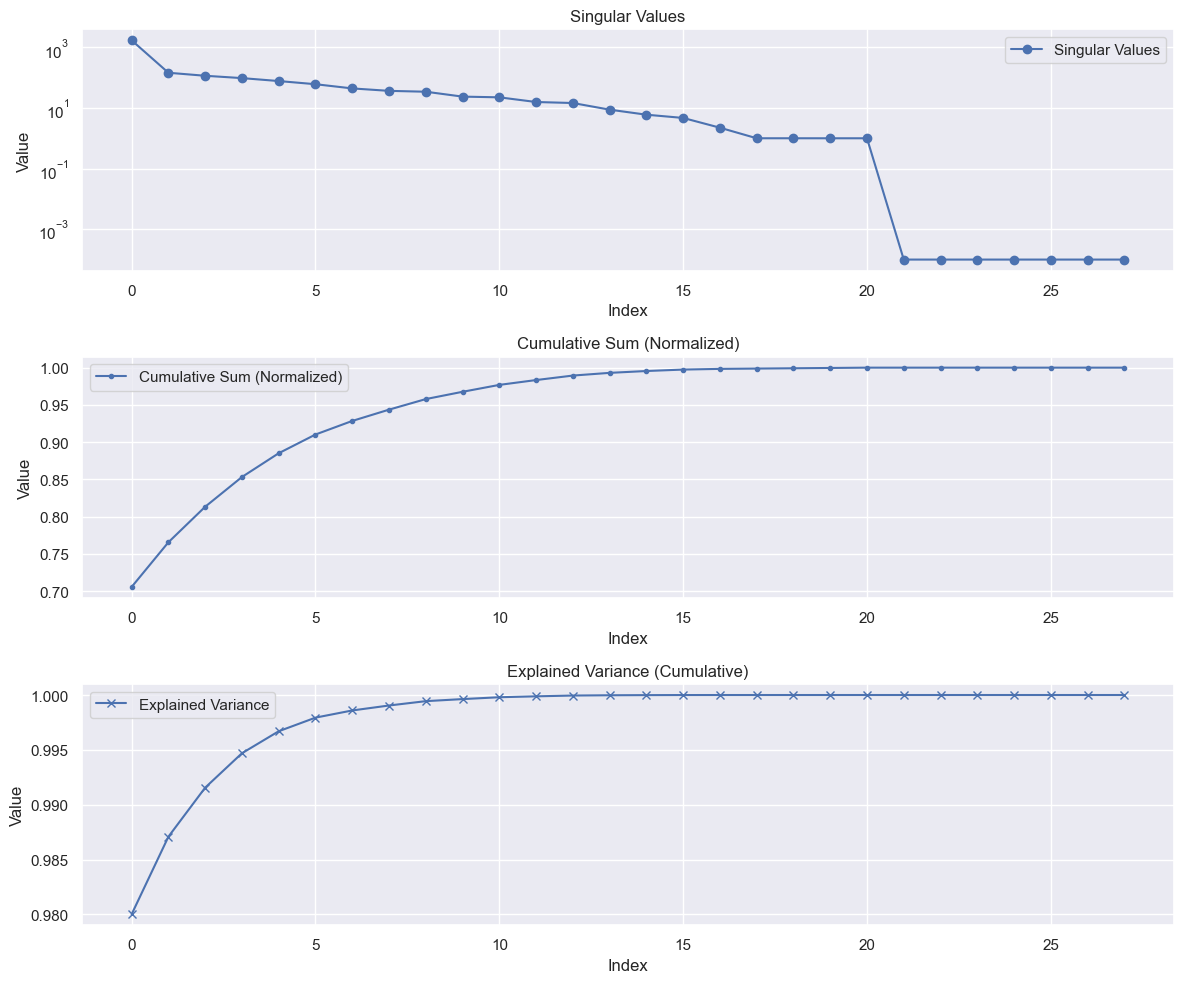

In [4]:
U, S, V = torch.linalg.svd(bon_train.float(), full_matrices=False)

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

axes[0].semilogy(S, marker='o', label='Singular Values')
axes[0].set_title('Singular Values')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Value')
axes[0].legend()

cumsum_norm = torch.cumsum(S, dim=0) / torch.sum(S)
axes[1].plot(cumsum_norm.numpy(), marker='.', label='Cumulative Sum (Normalized)')
axes[1].set_title('Cumulative Sum (Normalized)')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Value')
axes[1].legend()

explained_variance = S**2 / torch.sum(S**2)
explained_variance_cumsum = torch.cumsum(explained_variance, dim=0)
axes[2].plot(explained_variance_cumsum.numpy(), marker='x', label='Explained Variance')
axes[2].set_title('Explained Variance (Cumulative)')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Value')
axes[2].legend()

plt.tight_layout()
plt.show()


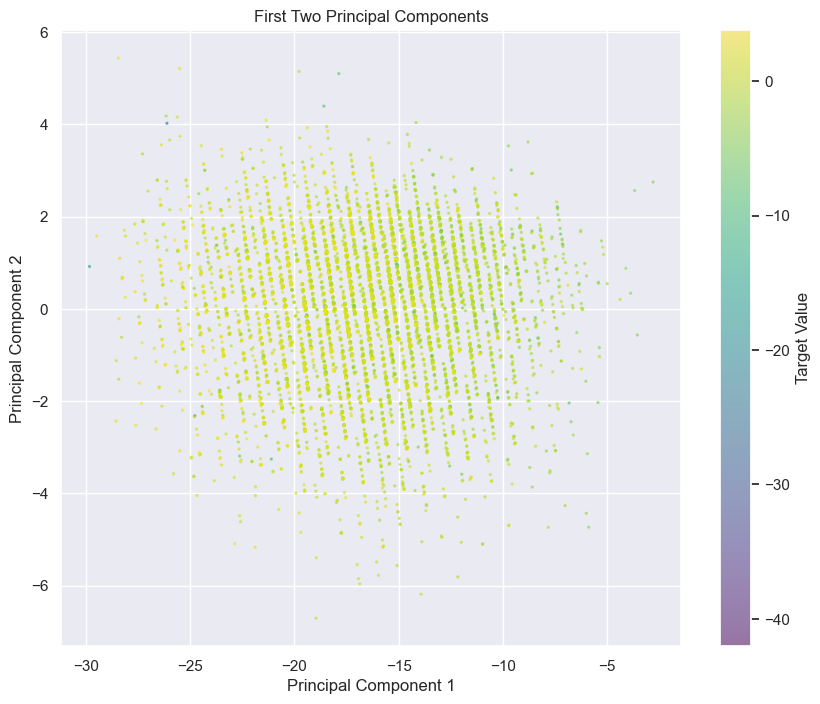

In [5]:
#Plot the first two principal components
Phi = bon_train.float() @ V.T
plt.figure(figsize=(10, 8))
plt.scatter(Phi[:, 0], Phi[:, 1], alpha=0.5, s=2, c=trainDataset.y, cmap='viridis')
plt.title('First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Target Value')
plt.show()

In [6]:
#Plot the first 3 principal components using plotly
import plotly.express as px
fig = px.scatter_3d(
    Phi.numpy(),
    x=0, y=1, z=2,
    color=trainDataset.y.numpy(),
    labels={'color': 'Target Value'},
    title='First Three Principal Components'
)

fig.update_traces(marker=dict(size=2))
fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    )
)
fig.show()

In [7]:
PrincipalComponents = Phi
PrincipalComponents_val = bon_val.float() @ V.T

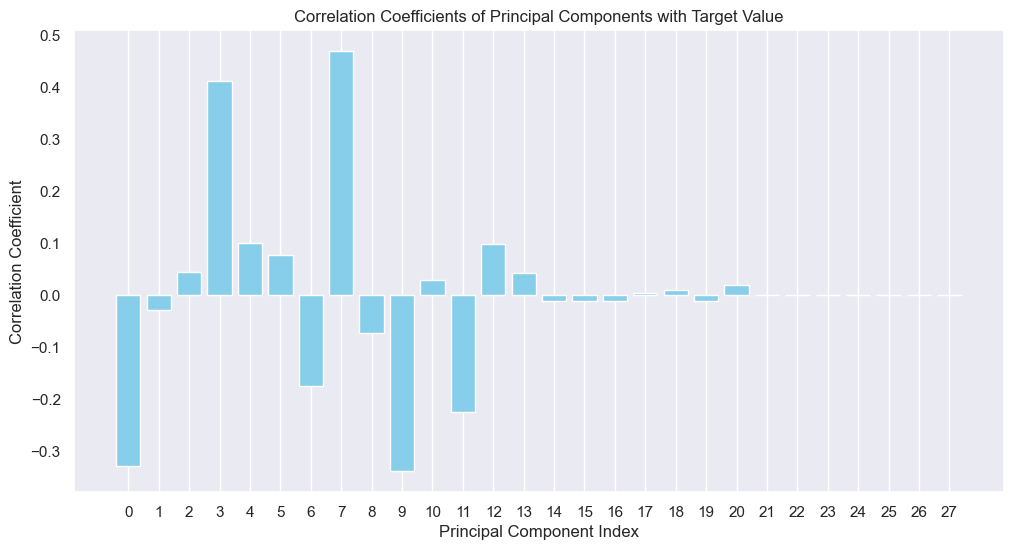

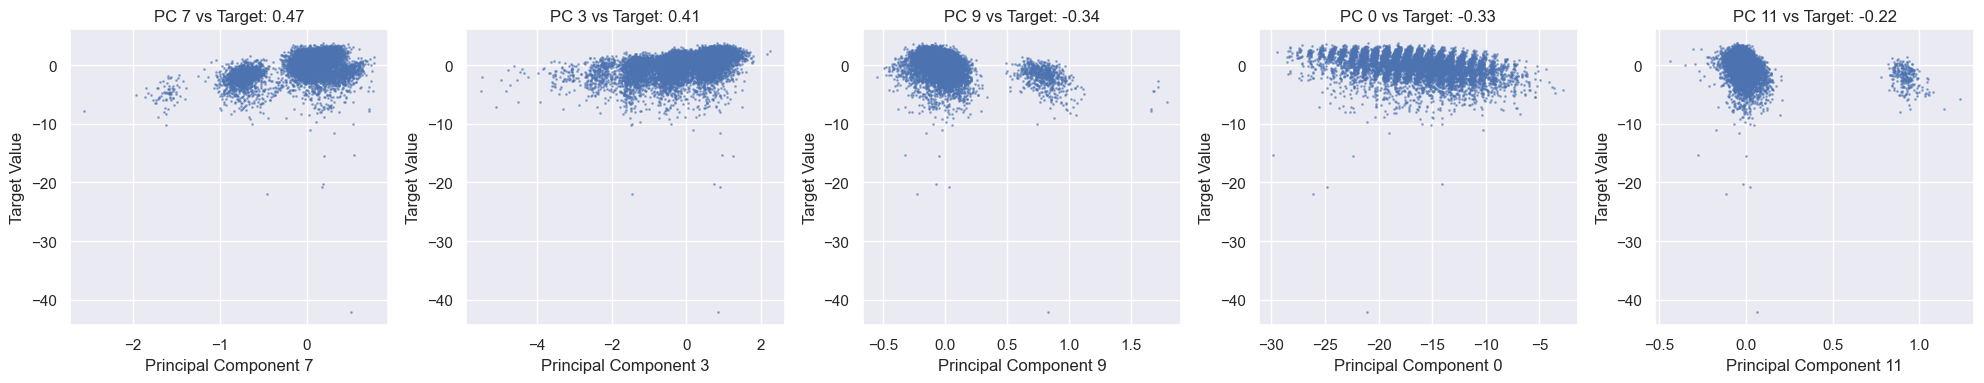

In [ ]:
#For each principal component plot the correlation coeff with the target value
corr_coeffs = np.array([np.corrcoef(PrincipalComponents[:, i].numpy(), trainDataset.y.numpy())[0, 1] for i in range(PrincipalComponents.shape[1])])
#Set nan values to 0
corr_coeffs = np.nan_to_num(corr_coeffs)
plt.figure(figsize=(12, 6))
plt.bar(range(PrincipalComponents.shape[1]), corr_coeffs, color='skyblue')
plt.title('Correlation Coefficients of Principal Components with Target Value')
plt.xlabel('Principal Component Index')
plt.ylabel('Correlation Coefficient')
plt.xticks(range(0, PrincipalComponents.shape[1]))
plt.grid(axis='y')
plt.show()

#Extracte the top 5 most correlated principal components and plot them against the target value, all in one figure different plots
top_indices = np.argsort(np.abs(corr_coeffs))[-5:][::-1]
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(top_indices):
    axes[i].scatter(PrincipalComponents[:, idx].numpy(), trainDataset.y.numpy(), alpha=0.5, s=1)
    axes[i].set_title(f'PC {idx} vs Target: {corr_coeffs[idx]:.2f}')
    axes[i].set_xlabel(f'Principal Component {idx}')
    axes[i].set_ylabel('Target Value')
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [51]:
top5_principal_components = PrincipalComponents[:, top_indices.copy()]
top5_principal_components_val = PrincipalComponents_val[:, top_indices.copy()]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 1.6805010048217492
R^2 Score: 0.573342124297403
Mean Absolute Error: 0.7589246279153672


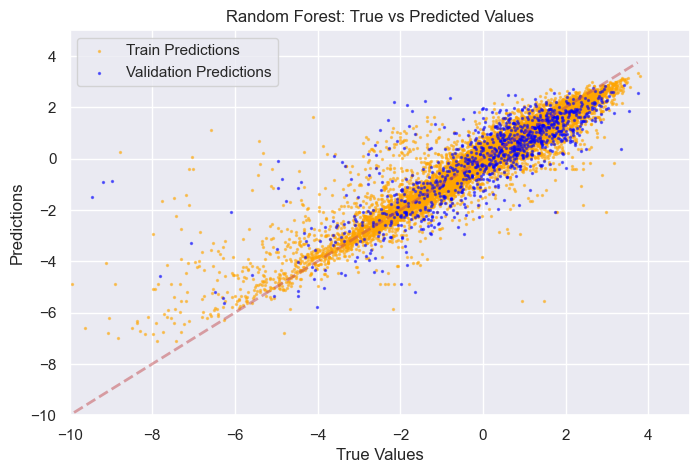

Mean Squared Error: 1.9171000719070435
R^2 Score: 0.5132726430892944
Mean Absolute Error: 0.830665647983551


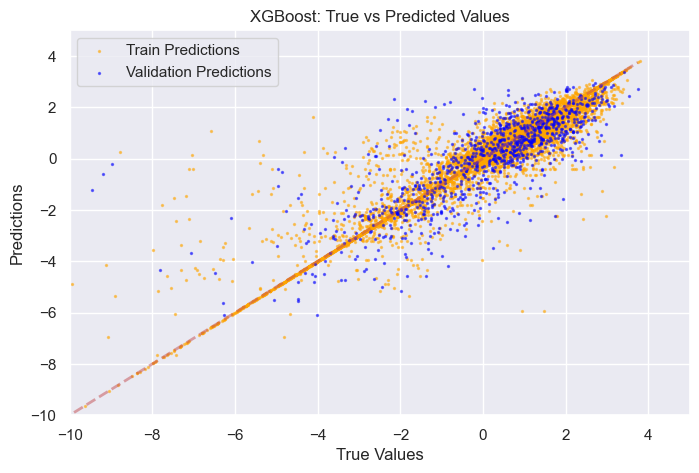

0.830665647983551

In [55]:
evaluateRF(PrincipalComponents, trainDataset.y.numpy(), PrincipalComponents_val, valDataset.y.numpy())
evaluateXGB(PrincipalComponents, trainDataset.y.numpy(), PrincipalComponents_val, valDataset.y.numpy())

Mean Squared Error: 1.5770492753408143
R^2 Score: 0.5996072053723038
Mean Absolute Error: 0.6688444345281441


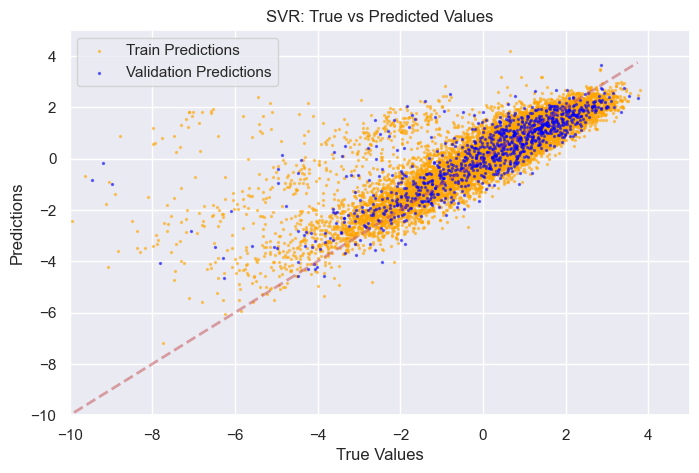

0.6688444345281441

In [57]:
evaluateSVR(PrincipalComponents, trainDataset.y.numpy(), PrincipalComponents_val, valDataset.y.numpy())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


Mean Squared Error: 1.7000953498186302
R^2 Score: 0.5683673687999854
Mean Absolute Error: 0.7764773043595397


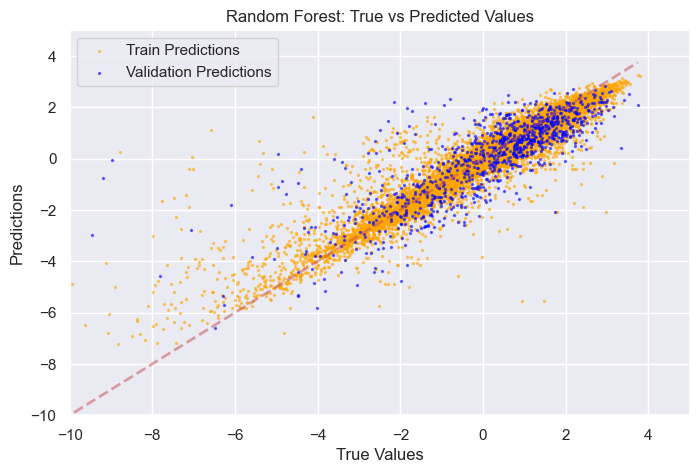

Mean Squared Error: 1.9048198461532593
R^2 Score: 0.5163904428482056
Mean Absolute Error: 0.8419862389564514


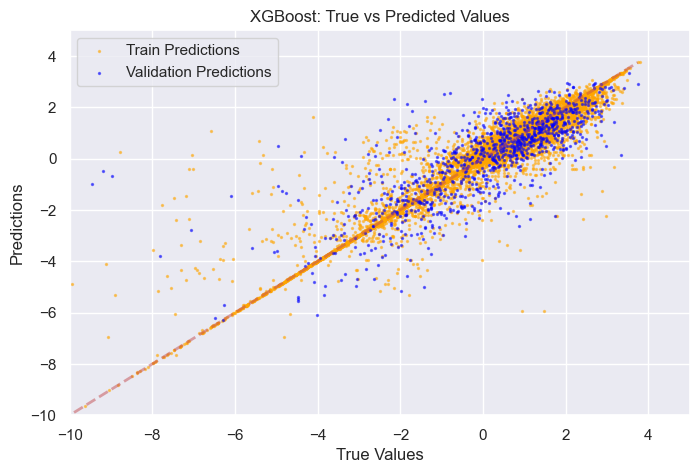

0.8419862389564514

In [54]:
evaluateRF(top5_principal_components, trainDataset.y.numpy(), top5_principal_components_val, valDataset.y.numpy())
evaluateXGB(top5_principal_components, trainDataset.y.numpy(), top5_principal_components_val, valDataset.y.numpy())

In [9]:
def create_enhanced_transform():
    """Create enhanced transformation with more features and augmentation"""
    
    transform_list = [
        oneHotTransform,  # Original node feature encoding
        # Add positional encodings
        T.AddRandomWalkPE(walk_length=16, attr_name='random_walk_pe'),
        T.AddLaplacianEigenvectorPE(k=8, attr_name='laplacian_pe'),
    ]
    
    def enhanced_transform(data):
        # Apply base transforms
        for transform in transform_list:
            try:
                data = transform(data)
            except:
                pass  # Skip if transform fails
        
        # Ensure float type for node features
        data.x = data.x.float()
        
        # Process edge attributes
        data.edge_attr = torch.nn.functional.one_hot(
            data.edge_attr.long(), num_classes=NUM_EDGE_FEATS
        ).float()
        
        # Concatenate additional node features if available
        additional_features = []
        
        if hasattr(data, 'random_walk_pe'):
            additional_features.append(data.random_walk_pe)
        
        if hasattr(data, 'laplacian_pe'):
            additional_features.append(data.laplacian_pe)
        
        if additional_features:
            data.x = torch.cat([data.x] + additional_features, dim=-1)
        
        return data
    
    return enhanced_transform